# 1 Generating Decision Trees

## Import Libs

In [107]:
import numpy as np
import secrets
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
%matplotlib inline

In [3]:
# Global Vars
EPS = np.finfo(float).eps
#EPS here is the smallest representable number. At times we get log(0) or 0 in the denominator, to avoid that we are going to use this.

In [4]:
# Generate secure random (not pseudo random) value between 0 and 1
def RNG_Prob():                     
    secGen=secrets.SystemRandom()   # secret generator
    n=secGen.random()
    return n

## Answer to Question 1.1

### Generate X, Y and w(weight) values

In [5]:
# generate m datapoints with k features each
def gen_X(k,m):
    pass

    # init. required 2D array i.e. our data points with features as empty
    X=np.empty((m,k)).astype(int)
    
    for i in range(m):
        # setting first feature 
        if(RNG_Prob()<0.5):
            X[i][0]=1
        else:
            X[i][0]=0
        
        # setting subsequent features
        for j in range(1,k):
            if(RNG_Prob()<0.75):
                X[i][j]=X[i][j-1]
            else:
                X[i][j]=1-X[i][j-1]
    return X


# generate weights corresponding to the features
def gen_w(k):
    pass

    # init. weight vector as empty 1D array
    w=np.empty((k))
    
    # calculate the denominator separately
    deno=0
    for i in range(2,k+1):
        deno+=pow(0.9,i)
    
    # setting weight values as per the given formula
    for i in range(1,k+1):
        w[i-1]=(pow(0.9,i))/deno
    return w


# generate the output column values from X and w
def gen_Y(k,m,X,w):
    pass

    # init. Y with as empty 1D array; each Y corresponds to each data point
    Y=np.empty((m)).astype(int)
    
    # setting up Y values as per the given function
    for i in range(m):
        val=0
        for j in range(1,k):
            val+=X[i][j]*w[j]
        if(val>=0.5):
            Y[i]=X[i][0]
        else:
            Y[i]=1-X[i][0]
    return Y

### Generate combined Dataset

In [6]:
# generating the complete dataset having Xs and Y
def gen_dataset(k,m):
    pass
    X=gen_X(k,m)
    w=gen_w(k)
    Y=gen_Y(k,m,X,w)
    
    # row index for X and Y
    rows=[]
    for i in range(m):
        rows.append("DataPoint "+str(i+1))
        
    # column header for X
    X_header=[]
    for i in range(k):
        X_header.append("X"+str(i+1))
        
    # creating corresponding DataFrames for X and Y
    X_df=pd.DataFrame(data=X, index=rows, columns=X_header)
    Y_df=pd.DataFrame(data=Y, index=rows, columns=["Y"])
    
    # merging the DataFrames
    dataset=X_df.merge(Y_df,left_index=True, right_index=True)
    return dataset

In [7]:
# init and test with given k and m values
k=4
m=30
dataset=gen_dataset(k,m)
dataset

,X1,X2,X3,X4,Y
DataPoint 1,1,1,1,1,1
DataPoint 2,1,1,1,1,1
DataPoint 3,1,1,1,1,1
DataPoint 4,0,0,0,0,1
DataPoint 5,1,1,1,1,1
DataPoint 6,0,1,1,0,0
DataPoint 7,1,0,0,0,0
DataPoint 8,0,0,0,0,1
DataPoint 9,0,0,0,1,1
DataPoint 10,1,1,1,0,1


## Answer to Question 1.2

In [8]:
# to find H(Y)
def get_entropy(data):
    # Taking the last column key (Y column)
    output=data.keys()[-1]
    entropy_Y=0
    
    # Taking unique values of Y
    output_vals=data[output].unique()

    #calc. entropy
    for val in output_vals:
        p_i=data[output].value_counts()[val]/len(data[output])
        entropy_Y+=-p_i*np.log2(p_i)
        
    return entropy_Y

In [9]:
# to find H(Y|X)
def get_entropy_attr(data,feature):
    # Taking the last column key (Y column)
    output=data.keys()[-1]
    
    # Taking unique values of Y
    output_vals=data[output].unique()
    
    # Taking unique values of X_i
    feature_vals=data[feature].unique()
    entropy_Y_X=0

    for x_val in feature_vals:
        entropy=0
        for y_val in output_vals:
            # calc. the number of data points that satisfy the feature and output values.
            numer=len(data[feature][data[feature]==x_val][data[output]==y_val])
            
            # calc. the total number of data points having feature as 0 or 1
            denom=len(data[feature][data[feature]==x_val])
            
            p_i=numer/(denom+EPS)
            entropy+=-(p_i)*np.log2(p_i+EPS)
        entropy_Y_X+=-(denom/len(data))*entropy

    return abs(entropy_Y_X)

In [10]:
# IG(X) = H(Y) - H(Y|X)
def IG_partition(data):
    IG=[]
    
    # For all X_i
    for key in data.keys()[:-1]:
        IG.append(get_entropy(data)-get_entropy_attr(data,key))

    return data.keys()[:-1][np.argmax(IG)]

In [11]:
def get_subtree(data,node,value):
    return data[data[node]==value]

In [12]:
def ID3_build_tree(data,tree=None):
    # Taking the last column key (Y column)
    output=data.keys()[-1]
    
    # partitioning based on node with max IG
    node=IG_partition(data)
    
    # Taking unique values of X_i
    feature_vals=data[node].unique()

    if tree is None:
        tree={}
        tree[node]={}

    for x_val in feature_vals:
        #get subtrees
        subtree=get_subtree(data,node,x_val)
        
        #get unique output values and its respective count
        output_val,output_counts=np.unique(subtree[subtree.keys()[-1]],return_counts=True)
        
        #if pure (==1 since we used .unique())
        if (len(output_counts)==1):
            tree[node][x_val]=output_val[0]
        #recursively create subtrees
        else:
            tree[node][x_val]=ID3_build_tree(subtree)        

    return tree

In [13]:
def fit2(row,tree):
    for node in tree.keys():
        value=row[node]
        tree=tree[node][value]
        prediction=0
        
        #if not empty
        #if type(tree) is dict:
        if isinstance(tree, dict):
            prediction=fit2(row, tree)
        else:
            prediction=tree
            break

    return prediction

In [14]:
def fit(data,tree):
    avg_err=0
    for i in range(len(data)):
        prediction=fit2(data.iloc[i], tree)
        
        #if prediction is equal to Y val.
        if prediction!=data.iloc[i][-1]:
            avg_err+=1
    
    #calc. avg error
    avg_err/=len(data)
    
    return avg_err

## Answer to Question 1.3

In [14]:
# init. k and m values to create dataset
k=4
m=30
dataset=gen_dataset(k,m)

In [41]:
#build tree with ID3 algo.
tree = ID3_build_tree(dataset)
tree

{'X3': {0: {'X1': {1: {'X4': {1: {'X2': {1: 1, 0: 0}}, 0: 0}},
    0: {'X2': {1: {'X4': {1: 0, 0: 1}}, 0: 1}}}},
  1: {'X1': {1: 1, 0: 0}}}}

In [42]:
err = fit(dataset, tree)
err

0.0

## Answer to Question 1.4

In [15]:
def get_typ_err(tree,k,m,MAX_ITER):
    typ_err=0
    for i in range(MAX_ITER):
        data=gen_dataset(k,m)
        typ_err+=fit(data,tree)

    typ_err=typ_err/MAX_ITER
    return typ_err

In [16]:
typ_err=get_typ_err(tree, k, m, 1000)
typ_err

NameError: name 'tree' is not defined

## Answer to Question 1.5

In [17]:
# Simulation for diff. values (list) of m
def gen_ds_sim(k,m):
    #error list
    err_ls=[]
    for val in m:
        dataset=gen_dataset(k, val)
        tree=ID3_build_tree(dataset)
        train_err=fit(dataset, tree)
        typ_err=get_typ_err(tree, k,val,50)
        err_ls.append(abs(train_err-typ_err))
    plt.plot(m,err_ls)
    plt.xlabel("m: No. of datapoints")
    plt.ylabel("Absolute diff. between training and typical error")
    plt.title("Plot for difference of error as a function of m")
    plt.show()
    return err_ls,m

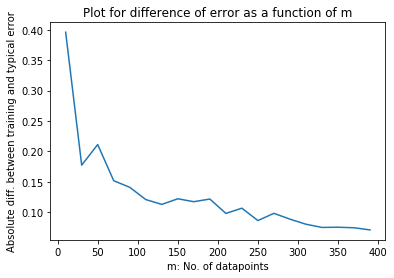

In [46]:
k=10
m_list=list(range(10,401,20))
err_ID3,m_ID3=gen_ds_sim(k,m_list)

## Answer to Question 1.6

In [16]:
def get_gini_w(data,feature):
    # Taking the last column key (Y column)
    output=data.keys()[-1] 
    
    # Taking unique values of Y
    output_vals=data[output].unique()
    
    # Taking unique values of X_i
    feature_vals=data[feature].unique()
    
    gini_w=0
    for x_val in feature_vals:
        gini = 1
        for y_val in output_vals:
            # calc. the number of data points that satisfy the feature and output values.
            numer=len(data[feature][data[feature]==x_val][data[output]==y_val])
            
            # calc. the total number of data points having feature as 0 or 1
            denom=len(data[feature][data[feature]==x_val])
            p_i=numer/(denom+EPS) 
            gini-=pow(p_i,2)
        gini_w+=(denom/len(data))*gini

    return gini_w

In [17]:
def gini_partition(data):
    gini=[]
    # For each X_i
    for key in data.keys()[:-1]:
        gini.append(get_gini_w(data,key))

    return data.keys()[:-1][np.argmin(gini)]

In [18]:
def gini_build_tree(data, tree=None):
    # Taking the last column key (Y column)
    output=data.keys()[-1]

    # partitioning based on node with max gini index
    node=gini_partition(data)
    
    # Taking unique values of X_i
    feature_vals=data[node].unique()

    #if doesn't exist, create empty dict.
    if tree is None:
        tree={}
        tree[node]={}

    for x_val in feature_vals:
        #get subtrees
        subtree=get_subtree(data,node,x_val)
        
        #if pure (==1 since we used .unique())
        output_val,output_counts=np.unique(subtree[subtree.keys()[-1]],return_counts=True)
        
        #if pure (==1 since we used .unique())
        if len(output_counts)==1:
            tree[node][x_val]=output_val[0]
        #recursively create subtrees
        else:
            tree[node][x_val]=gini_build_tree(subtree)        

    return tree 

In [50]:
tree_gini=gini_build_tree(dataset)
tree_gini

{'X3': {0: {'X1': {1: {'X4': {1: {'X2': {1: 1, 0: 0}}, 0: 0}},
    0: {'X2': {1: {'X4': {1: 0, 0: 1}}, 0: 1}}}},
  1: {'X1': {1: 1, 0: 0}}}}

In [51]:
err=fit(dataset,tree_gini)
err

0.0

In [52]:
typ_err=get_typ_err(tree_gini,k,m,1000)
typ_err

0.20076666666666543

In [19]:
# Simulation for diff. values (list) of m
def gen_gini_ds_sim(k,m):
    #error list
    err_ls=[]
    for val in m:
        dataset=gen_dataset(k, val)
        tree=gini_build_tree(dataset)
        train_err=fit(dataset, tree)
        typ_err=get_typ_err(tree, k, val, 50)
        err_ls.append(abs(train_err-typ_err))
    plt.plot(m,err_ls)
    plt.xlabel("m: No. of datapoints")
    plt.ylabel("Absolute diff. between training and typical error")
    plt.title("Plot for difference of error as a function of m")
    plt.show()
    return err_ls, m

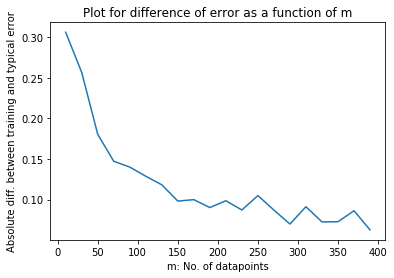

In [54]:
k=10
m_list=list(range(10, 401, 20))
err_gini, m_gini = gen_gini_ds_sim(k,m_list)

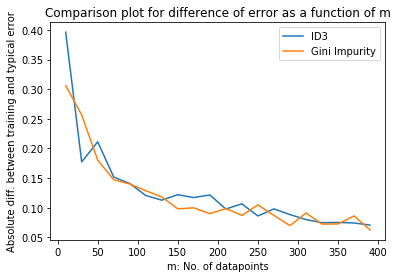

In [55]:
plt.plot(m_ID3, err_ID3, label="ID3")
plt.plot(m_gini, err_gini, label="Gini Impurity")
plt.xlabel("m: No. of datapoints")
plt.ylabel("Absolute diff. between training and typical error")
plt.title("Comparison plot for difference of error as a function of m")
plt.legend()
plt.show()

# End of 1 Generating Decision Trees

In [38]:
#tree = ID3_build_tree(dataset)
tree
import pprint
pprint.pprint(tree)

{'X5': {0: {'X8': {0: {'X0': {0: 0,
                              1: {'X11': {0: 0, 1: {'X13': {0: 0, 1: 1}}}}}},
                   1: {'X3': {0: {'X1': {0: 0,
                                         1: {'X11': {0: {'X0': {0: 1, 1: 0}},
                                                     1: {'X0': {0: 0,
                                                                1: 1}}}}}},
                              1: {'X9': {0: 0, 1: 1}}}}}},
        1: {'X13': {0: {'X0': {0: {'X2': {0: {'X4': {0: 0,
                                                     1: {'X6': {0: 0, 1: 1}}}},
                                          1: 1}},
                               1: {'X11': {0: 0,
                                           1: {'X9': {0: {'X3': {0: 1, 1: 0}},
                                                      1: 1}}}}}},
                    1: {'X3': {0: {'X7': {0: {'X8': {0: 0, 1: 1}}, 1: 1}},
                               1: 1}}}}}}


## =========================================================

# 2 Pruning Decision Trees

## Answer to Question 2.1

In [20]:
# generate m datapoints with 21 features each
def gen_X2(m):
    pass

    # init. required 2D array i.e. our data points with features as empty
    X=np.empty((m,21)).astype(int)
    
    for i in range(m):
        # setting first feature 
        if(RNG_Prob()<0.5):
            X[i][0]=1
        else:
            X[i][0]=0
        
        # setting subsequent (X1 to X14) features
        for j in range(1,15):
            if(RNG_Prob()<0.75):
                X[i][j]=X[i][j-1]
            else:
                X[i][j]=1-X[i][j-1]
                
        # setting subsequent (X15 to X20) features (noise)
        for j in range(15,21):
            if(RNG_Prob()<0.5):
                X[i][j]=1
            else:
                X[i][j]=0
    return X


def gen_Y2(m,X):
    pass

    # init. Y with as empty 1D array; each Y corresponds to each data point
    Y=np.empty((m)).astype(int)
    
    for i in range(m):
        if(X[i][0]==0):
            List=X[i][1:8].tolist()
            Y[i]=max(set(List),key=List.count)
        elif(X[i][0]==1):
            List=X[i][8:15].tolist()
            Y[i]=max(set(List),key=List.count)
    return Y


# generating the complete dataset having Xs and Y
def gen_dataset2(m):
    pass
    X=gen_X2(m)
    Y=gen_Y2(m,X)
    
    # row index for X and Y
    rows=[]
    for i in range(m):
        rows.append("DataPoint "+str(i+1))
        
    # column header for X
    X_header=[]
    for i in range(21):
        X_header.append("X"+str(i))
        
    # creating corresponding DataFrames for X and Y
    X_df=pd.DataFrame(data=X, index=rows, columns=X_header)
    Y_df=pd.DataFrame(data=Y, index=rows, columns=["Y"])
    
    # merging the DataFrames
    dataset=X_df.merge(Y_df,left_index=True, right_index=True)
    return dataset

In [108]:
m=100
dataset=gen_dataset2(m)
dataset

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
DataPoint 1,0,0,0,0,1,0,0,0,0,0,...,1,1,1,0,0,1,1,1,1,0
DataPoint 2,1,1,0,1,0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,1,0
DataPoint 3,1,0,0,0,1,1,1,0,0,0,...,0,0,0,1,0,1,1,1,1,0
DataPoint 4,0,0,0,1,1,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
DataPoint 5,0,0,0,0,0,0,1,1,1,1,...,1,0,0,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DataPoint 96,0,0,0,1,1,1,1,0,0,1,...,0,0,0,0,1,1,0,1,1,1
DataPoint 97,1,0,0,0,0,1,1,1,1,0,...,0,0,0,1,0,0,1,0,0,0
DataPoint 98,0,1,1,1,1,0,0,0,0,0,...,1,1,1,1,1,1,1,0,1,1
DataPoint 99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,0


In [109]:
tree = ID3_build_tree(dataset)
tree

{'X3': {0: {'X2': {0: {'X7': {0: 0,
      1: {'X14': {0: 0, 1: {'X0': {1: 1, 0: {'X4': {0: 0, 1: 1}}}}}}}},
    1: {'X11': {1: {'X0': {1: 1, 0: 0}}, 0: {'X7': {1: 1, 0: 0}}}}}},
  1: {'X9': {1: {'X5': {0: {'X16': {0: 0, 1: 1}}, 1: 1}},
    0: {'X0': {0: {'X4': {1: 1, 0: {'X6': {1: 1, 0: 0}}}},
      1: {'X10': {0: 0, 1: 1}}}}}}}}

In [111]:
start = timer()
err = fit(dataset, tree)
print("Time taken: ", timer()-start)
err

Time taken:  0.02716359999976703


0.0

In [112]:
def get_typ_err2(tree, m, MAX_ITER):
    typ_err = 0
    for i in range(MAX_ITER):
        data=gen_dataset2(m)
        typ_err+=fit(data,tree)

    typ_err/=MAX_ITER
    return typ_err

In [113]:
# Simulation for diff. values (list) of m
def gen_ds_sim2():
    #m = list(range(10, 2001, 100))
    err_ls=[]
    for val in m:
        dataset = gen_dataset2(val)
        tree = ID3_build_tree(dataset)
        train_err = fit(dataset, tree)
        typ_err = get_typ_err2(tree,val,50)
        err_ls.append(abs(train_err - typ_err))
    plt.plot(m, err_ls)
    plt.xlabel("m: No. of datapoints")
    plt.ylabel("Absolute diff. between training and typical error")
    plt.title("Plot for difference of error as a function of m")
    plt.show()
    return err_ls

[10, 210, 410, 610, 810, 1010, 1210, 1410, 1610, 1810, 2010, 2210, 2410]


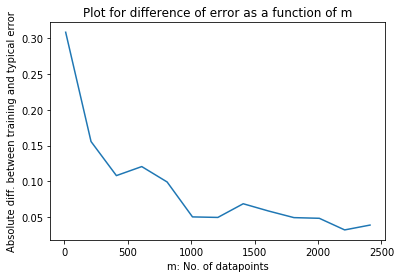

In [76]:
#m=list(range(10, 10001, 1))
m=list(range(10, 2411, 200))
print(m)
typical_error=gen_ds_sim2()

## Answer to Question 2.2

In [114]:
# get list of features (i.e. nodes in the decision tree) 
# which were considered relevant by the algorithm
# rvl=relevant variable list
def get_unique_rvl(d, rvl):
    for key, value in d.items():
        if(isinstance(key, str)):        
            rvl.append(key)
        if isinstance(value, dict):
            get_unique_rvl(value, rvl)
            
    return set(rvl)

In [115]:
# get irrelevant var count by comparing with relevant vars
# ivc=irrelevant variable count
def get_ivc(ivl,rvl):
    count=0
    for item in ivl:
        if item in rvl:
            count+=1
    return count

In [117]:
# simulation function for getting avg. irrevant variables
# for given size of dataset
def ivc_sim(m,MAX_ITER):
    # ivc_ls=irrelevant variable count list
    ivc_ls = []
    ivl = ['X15', 'X16', 'X17', 'X18', 'X19','X20']
    
    for m_i in m:
        count = []
        for j in range(MAX_ITER):
            dataset2 = gen_dataset2(m_i)
            tree = ID3_build_tree(dataset2)
            rvl=[]
            get_unique_rvl(tree,rvl)
            count.append(get_ivc(ivl,rvl))
            
        ivc_ls.append(sum(count)/len(count))
    
    
    plt.plot(m, ivc_ls)
    plt.xlabel("m: No. of datapoints")
    plt.ylabel("Avg. number of irrelevant variables")
    plt.title("Plot for average irrelevant variables")
    plt.show()

m values (List) = [1000, 8000, 15000, 22000, 29000, 36000, 43000, 50000]


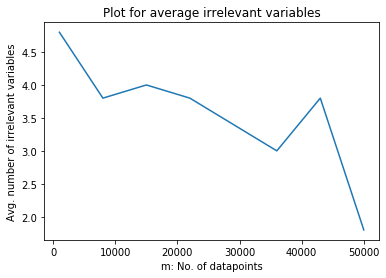

Time taken:  2388.143747099999


In [118]:
# running the simulation
m=list(range(1000,50001,7000))
print("m values (List) =",m)
MAX_ITER=5
start = timer()
ivc_sim(m,MAX_ITER)
print("Time taken: ", timer()-start)

## Answer to Question 2.3

In [25]:
new_dataset=gen_dataset2(10000)

In [26]:
train_set=new_dataset[:8000]
test_set=new_dataset[8000:]

In [120]:
tree = ID3_build_tree(train_set)

In [121]:
def get_max_depth(d, depth=[], start=0):
    for key, value in d.items():
        if(isinstance(key, str)):
            #depth.append(start+1)
            depth.append((start+2)/2)
        if isinstance(value, dict):
            get_max_depth(value, depth, start=start+1)
            
    return sorted(set(depth))[-1]+1

In [122]:
# def print_depth(d, start=0):
#     for key, value in d.items():
#         if(isinstance(key, str)):
#             print(key, (start + 2)/2)
#         if (isinstance(value, dict)): #and isinstance(key, str)):
#             print_depth(value, start=start+1)
# #         else:
# #             print_depth(value, start=start)

In [123]:
train_error=fit(train_set,tree)
train_error

0.0

In [124]:
test_error=fit(test_set,tree)
test_error

0.0195

In [125]:
# tree=ID3_build_tree(dataset)
# pprint.pprint(tree)
# #print(get_max_depth(tree))

In [40]:
# #delete later
# print(get_max_depth(tree))

11


In [126]:
# def print_depth(d, start=0):
#     for key, value in d.items():
#         print(key, start + 1)
#         if isinstance(value, dict):
#             print_depth(value, start=start+1)

In [127]:
# testDict={'X4': {0: {'X1': {0: {'X2': {0: 1, 1: 0}},
#                    1: {'X3': {0: 0, 1: {'X2': {0: 0, 1: 1}}}}}},
#         1: {'X1': {0: {'X2': {0: 1, 1: 0}},
#                    1: {'X2': {0: {'X3': {0: 0, 1: 1}}, 1: 1}}}}}}
# testDict

In [68]:
def ID3_build_tree_depth(data, depth_threshold, tree=None):
    output = data.keys()[-1]
    
    node = IG_partition(data)
    
    feature_vals = data[node].unique()

    
    
    if tree is None:
        tree = {}
        tree[node] = {}
    
    #testing
    pprint.pprint(tree)
    
    print("curr depth A: ",get_max_depth(tree,[]))
    
    for val in feature_vals:
        print("curr depth B: ",get_max_depth(tree,[]))
        subtree = get_subtree(data, node, val)
        output_val, output_counts = np.unique(subtree[subtree.keys()[-1]], return_counts=True)
        if len(output_counts) == 1:
            print("here1", tree)
            tree[node][val] = output_val[0]
        else:
            print("curr depth C: ",get_max_depth(tree,[]))
            if(get_max_depth(tree,[],0)<depth_threshold):
                print(get_max_depth(tree,[],0))
                print("here2")
                tree[node][val] = ID3_build_tree_depth(subtree, depth_threshold)
            else:
                print("here3", depth_threshold, get_max_depth(tree,[]))
                tree[node][val] = max(set(output_val.tolist()),key=output_val.tolist().count)
        

                
    return tree

In [106]:
depth_thresh=4
#tree2={}
#start=0
tree=ID3_build_tree_depth(train_set, depth_thresh-1)
pprint.pprint(tree2)
print(get_max_depth(tree,[]))
#print(print_depth(tree2))

{'X4': {}}
curr depth A:  2.0
curr depth B:  2.0
curr depth C:  2.0
2.0
here2
{'X1': {}}
curr depth A:  2.0
curr depth B:  2.0
curr depth C:  2.0
2.0
here2
{'X2': {}}
curr depth A:  2.0
curr depth B:  2.0
here1 {'X2': {}}
curr depth B:  2.0
curr depth C:  2.0
2.0
here2
{'X3': {}}
curr depth A:  2.0
curr depth B:  2.0
here1 {'X3': {}}
curr depth B:  2.0
here1 {'X3': {0: 0}}
curr depth B:  4.0
curr depth C:  4.0
here3 3 4.0
curr depth B:  5.0
curr depth C:  5.0
here3 3 5.0
{'X4': {0: 0, 1: {'X1': {0: 0, 1: {'X2': {0: {'X3': {0: 0, 1: 1}}, 1: 1}}}}}}
5.0


In [ ]:
def pruning_by_depth(depth):
    
    train_error=[]
    test_error=[]
    for d_i in depth:
        tree=ID3_build_tree_depth(train_set, d_i)
        
        train_error.append(fit(train_set,tree))
        test_error.append(fit(test_set,tree))
        
    plt.plot(depth, train_error, marker='', color='blue', linewidth=2, label="Training error")
    plt.plot(depth, test_error, marker='', color='green', linewidth=2, linestyle='dashed', label="Testing error")
    plt.xlabel("Value of Depth Level")
    plt.ylabel("Errors")
    plt.title("Pruning by Depth Level")
    plt.legend()
    plt.show()

In [ ]:
depth=list(range(1, 14))
pruning_by_depth(depth)

In [131]:
def get_freq(subtree):
    output_val, output_counts = np.unique(subtree[subtree.keys()[-1]], return_counts=True)
    if len(output_counts) == 1:
        return output_val[0]
    else:
        if output_counts[1] > output_counts[0]:
            return output_val[1]
        else:
            return output_val[0]

In [132]:
def ID3_build_tree_sample(data, size, tree=None):
    output = data.keys()[-1]
    node = IG_partition(data)
    feature_vals = data[node].unique()
    
    if tree is None:
        tree = {}
        tree[node] = {}

    for val in feature_vals:
        if len(data) <= size:
            tree[node][val] = get_freq(data)
        else:
            subtree = get_subtree(data, node, val)
            output_val, output_counts = np.unique(subtree[subtree.keys()[-1]], return_counts=True)
            if len(output_counts) == 1:
                tree[node][val] = output_val[0]
            else:
                tree[node][val] = ID3_build_tree_sample(subtree, size)


                
    return tree

In [157]:
def pruning_by_sample_size_sim(size):
    train_error=[]
    test_error=[]
    for size_i in size:
        tree = ID3_build_tree_sample(train_set, size_i)
        
        train_error.append(fit(train_set,tree))
        test_error.append(fit(test_set,tree))

    plt.plot(size, train_error,label="Training error")
    plt.plot(size, test_error,label="Testing error")
    plt.xlabel("Sample Size")
    plt.ylabel("Error")
    plt.title("Plot for Pruning: Sample Size vs Error")
    plt.legend()
    plt.show()

size values (List) = [1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901]


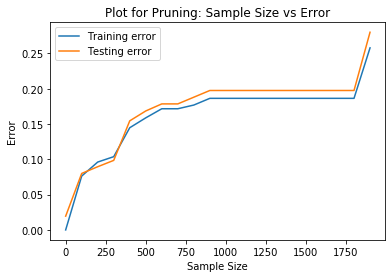

Time taken:  255.0669001999995


In [159]:
size = list(range(1, 2001, 100))
print("size values (List) =",size)
start = timer()
pruning_by_sample_size_sim(size)
print("Time taken: ", timer()-start)

In [141]:
# size = list(range(2001, 0, -100))
# print(size)

[2001, 1901, 1801, 1701, 1601, 1501, 1401, 1301, 1201, 1101, 1001, 901, 801, 701, 601, 501, 401, 301, 201, 101, 1]


## Answer to Question 2.4

#### Question 2.4 doesn't exist in the given Homework

## Answer to Question 2.5

## Answer to Question 2.6

In [151]:
# def ivc_sim(m,MAX_ITER):
#     ivc = []
#     ivl = ['X15', 'X16', 'X17', 'X18', 'X19','X20']
#     for m_i in m:
#         count = []
#         for j in range(MAX_ITER):
#             train_data = gen_dataset(m_i)
#             tree = ID3_build_tree(train_data)
#             rvl=[]
#             get_unique_rvl(tree,rvl)
#             count.append(get_ivc(ivl,rvl))
            
#         ivc.append(sum(count)/len(count))
    
#     plt.plot(m, ivc)
#     plt.xlabel("Value of m (sample size)")
#     plt.ylabel("Count of irrelevant columns")
#     plt.title("Irrelevant columns as a function of m")
#     plt.show() 

In [153]:
def ivc_sim_size(m,MAX_ITER,size):
    ivc = []
    ivl = ['X15', 'X16', 'X17', 'X18', 'X19','X20']
    for m_i in m:
        count = []
        for j in range(MAX_ITER):            
            train_data = gen_dataset2(m_i)
            tree = ID3_build_tree_sample(train_data, size)
        
            rvl=[]
            get_unique_rvl(tree,rvl)
            count.append(get_ivc(ivl,rvl))
            
        ivc.append(sum(count)/len(count))
    
    plt.plot(m, ivc)
    plt.xlabel("m: No. of datapoints")
    plt.ylabel("Avg. number of irrelevant variables")
    plt.title("Plot for average irrelevant variables")
    plt.show() 

m values (List) = [1000, 8000, 15000, 22000, 29000, 36000, 43000, 50000]


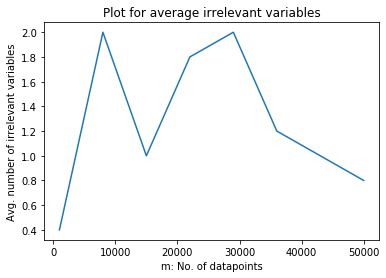

Time taken:  2054.1800702


In [161]:
m=list(range(1000,50001,7000))
print("m values (List) =",m)
MAX_ITER=5
# Taking 50 from Answer 2.3 b
size=50
start = timer()
ivc_sim_size(m,MAX_ITER,size)
print("Time taken: ", timer()-start)

In [ ]:
# def tree_with_fixed_sample_size():
#     sample_size = 50
#     samples = [101, 500, 1000, 2500, 5000, 10000, 30000, 70000]
#     ivc = []
#     irrelevant_variable = ['X15', 'X16', 'X17', 'X18', 'X19','X20']
#     for i in tqdm(range(len(samples))):
#         count = []
#         for j in range(5):
#             train_data = create_dataset(k, samples[i])
#             dt = DecisionTreeWithNode(min_sample_size=sample_size)
#             dt.fit(train_data, 'Y')
#             count.append(len(dt.get_irrelevant_variable(irrelevant_variable)))
            
#         ivc.append(sum(count)/len(count))
    
#     plt.plot(samples, ivc)
#     plt.xlabel("Value of m (sample size)")
#     plt.ylabel("Count of irrelevant columns")
#     plt.title("Irrelevant columns as a function of m")
#     plt.show()

In [ ]:
# tree_with_fixed_sample_size()

# End of 2 Pruning Decision Trees

In [ ]:
m = list(range(10, 2000, 100))

In [ ]:
m

In [ ]:
def most_frequent(List): 
    return max(set(List), key = List.count) 
  


In [ ]:
List = [2, 1, 2, 2, 1, 3] 
print(most_frequent(List)) 

In [ ]:
List.count